# Промышленность — задача проекта
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Исследовательский анализ данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Напишем функцию для анализа каждого датафрейма
def all_info(df):
    df.info()
    display(df.head())
    display(df.describe())
    print('Количество пропусков:')
    print('\n')
    print(df.isna().sum())
    print('\n')
    print('Количество дубликатов:', df.duplicated().sum())

In [3]:
#Изучим файлы
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Данные об электродах

In [4]:
#Изучим датафрейм data_arc
all_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество пропусков:


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


Количество дубликатов: 0


In [5]:
#Переименуем столбцы и приведём столбцы с датами к правильному формату
data_arc.columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']
data_arc['start_arc_heating'] = pd.to_datetime(data_arc['start_arc_heating'])
data_arc['end_arc_heating'] = pd.to_datetime(data_arc['end_arc_heating'])

In [6]:
#Посмотрим наименьшие значения с сортировкой по столбцу 'reactive_power'
data_arc.sort_values(by = ['reactive_power']).head(10)

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983
676,146,2019-05-08 19:18:55,2019-05-08 19:19:07,0.035400,0.023228
4063,873,2019-06-04 18:34:19,2019-06-04 18:34:30,0.040905,0.023569
6580,1432,2019-06-23 21:13:19,2019-06-23 21:13:34,0.034053,0.025329
8704,1892,2019-07-09 18:51:37,2019-07-09 18:51:50,0.038364,0.026079
4615,996,2019-06-08 22:06:27,2019-06-08 22:09:03,0.035165,0.026222


In [7]:
#Изучим подробнее ключ с наименьшим значением
data_arc[data_arc['key'] == 2116]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [8]:
#Изучим предыдущий ключ
data_arc[data_arc['key'] == 2115]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9775,2115,2019-07-24 00:01:00,2019-07-24 00:02:58,0.470668,0.348211
9776,2115,2019-07-24 00:09:25,2019-07-24 00:11:49,0.665501,0.435063
9777,2115,2019-07-24 00:21:20,2019-07-24 00:22:21,0.259949,0.175169


In [9]:
#Выделим данные с 2115 ключа отдельно
data_arc_2115 = data_arc.iloc[9775:9778]

In [10]:
#Изучим корреляцию между 'reactive_power' и 'active_power' для 2115 ключа
round(data_arc_2115['reactive_power'].corr(data_arc_2115['active_power']), 2)

0.99

In [11]:
#Рассчитаем средний коэффициент
average_coeff = sum(data_arc_2115.reactive_power / data_arc_2115.active_power) / 3

In [12]:
#Теперь заменим аномальное значение в 9780 строке на нормальное
data_arc.at[9780, 'reactive_power'] = data_arc.iloc[9780].active_power * average_coeff

In [13]:
#Проверим изменения
data_arc[data_arc['key'] == 2116]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,0.341664
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


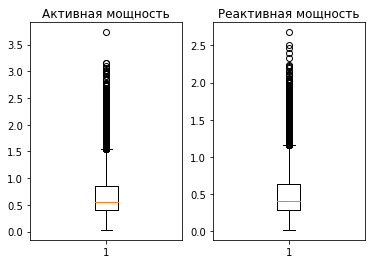

In [14]:
#Построим 'ящики с усами'
fig, axs = plt.subplots(1, 2)
axs[0].boxplot(data_arc['active_power'])
axs[0].set_title('Активная мощность')
axs[1].boxplot(data_arc['reactive_power'])
axs[1].set_title('Реактивная мощность')
plt.show()

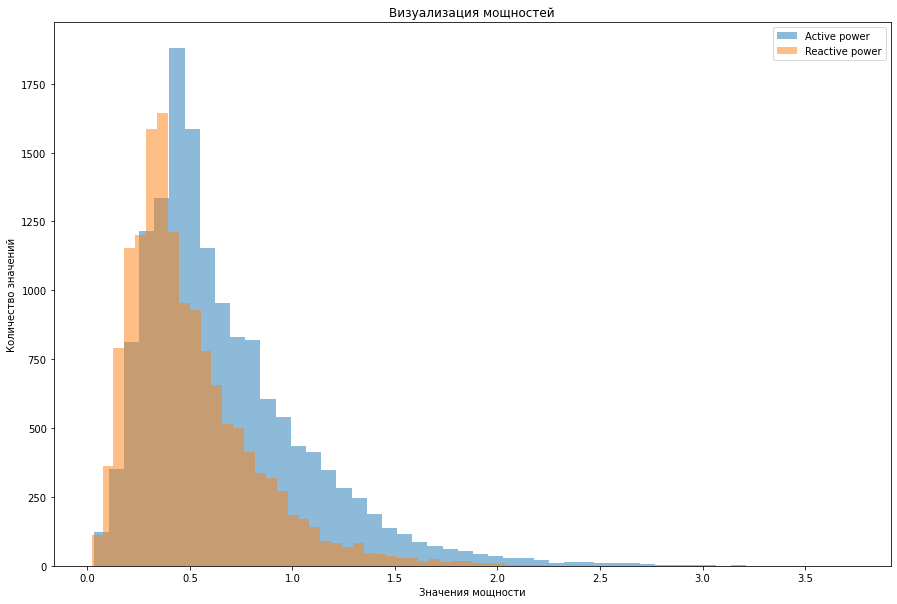

In [15]:
#Построим гистограммы
plt.subplots(figsize=(15, 10))
plt.hist(data_arc['active_power'], bins=50, alpha = 0.5, label='Active power')
plt.hist(data_arc['reactive_power'], bins=50, alpha = 0.5, label='Reactive power')
plt.title('Визуализация мощностей')
plt.xlabel('Значения мощности')
plt.ylabel('Количество значений')
plt.legend()
plt.show()

In [16]:
#Проверим изменения
all_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_arc_heating  14876 non-null  datetime64[ns]
 2   end_arc_heating    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.500713
std,934.571502,0.408159,0.310873
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.291008
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество пропусков:


key                  0
start_arc_heating    0
end_arc_heating      0
active_power         0
reactive_power       0
dtype: int64


Количество дубликатов: 0


### Вывод

С данными по большей части всё в порядке, но произошли небольшие изменения:
- было заменено 1 аномальное значение в столбце 'reactive_power';
- названия столбцов приведены к стилистически правильному виду;
- изменён тип данных с датами на более корректный;

### Данные о подаче сыпучих материалов

In [17]:
#Изучим датафрейм
all_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


Количество дубликатов: 0


In [18]:
#Изучим датафрейм со временем
all_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


Количество дубликатов: 0


In [19]:
#Приведём названия столбцов к правильному виду
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                     'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                          'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [20]:
#Посмотрим количество непустых значений в столбцах
data_bulk.count().sort_values(ascending=False)

key        3129
bulk_14    2806
bulk_12    2450
bulk_15    2248
bulk_3     1298
bulk_4     1014
bulk_6      576
bulk_1      252
bulk_11     177
bulk_10     176
bulk_5       77
bulk_7       25
bulk_2       22
bulk_9       19
bulk_13      18
bulk_8        1
dtype: int64

In [21]:
#Удалим столбцы, у которых очень много пропусков
data_bulk_new = data_bulk.drop(columns=['bulk_8', 'bulk_13', 'bulk_9', 'bulk_2', 'bulk_7', 'bulk_5', 'bulk_10', 'bulk_11',
                                         'bulk_1'], axis=1)
data_bulk_time_new = data_bulk_time.drop(columns=['bulk_8', 'bulk_13', 'bulk_9', 'bulk_2', 'bulk_7', 'bulk_5', 'bulk_10', 
                                                   'bulk_11', 'bulk_1'], axis=1)

In [22]:
#Напишем функцию, которая объединит 2 датафрейма и приведёт файл к удобному формату для просмотра
def function(data_1, data_2):
    data_1_new = data_1.set_index('key').stack().reset_index()
    data_2_new = data_2.set_index('key').stack().reset_index()
    data_joined = data_2_new.merge(data_1_new, on=['key', 'level_1'])
    data_joined.columns = ['key', 'variable', 'datetime', 'value']
    return data_joined

In [23]:
#Применим функцию и посмотрим изменения
data_bulk_good = function(data_bulk_new, data_bulk_time_new)
data_bulk_good

,key,variable,datetime,value
0,1,bulk_4,2019-05-03 11:21:30,43.0
1,1,bulk_12,2019-05-03 11:03:52,206.0
2,1,bulk_14,2019-05-03 11:03:52,150.0
3,1,bulk_15,2019-05-03 11:03:52,154.0
4,2,bulk_4,2019-05-03 11:46:38,73.0
...,...,...,...,...
10387,3240,bulk_6,2019-09-01 03:12:40,26.0
10388,3240,bulk_14,2019-09-01 02:41:27,192.0
10389,3240,bulk_15,2019-09-01 02:41:27,54.0
10390,3241,bulk_14,2019-09-01 04:05:34,180.0


In [24]:
#Приведём столбцы с датами и значениями к правильному виду
data_bulk_good['datetime'] = pd.to_datetime(data_bulk_good['datetime'])
data_bulk_good['value'] = data_bulk_good['value'].astype('int')

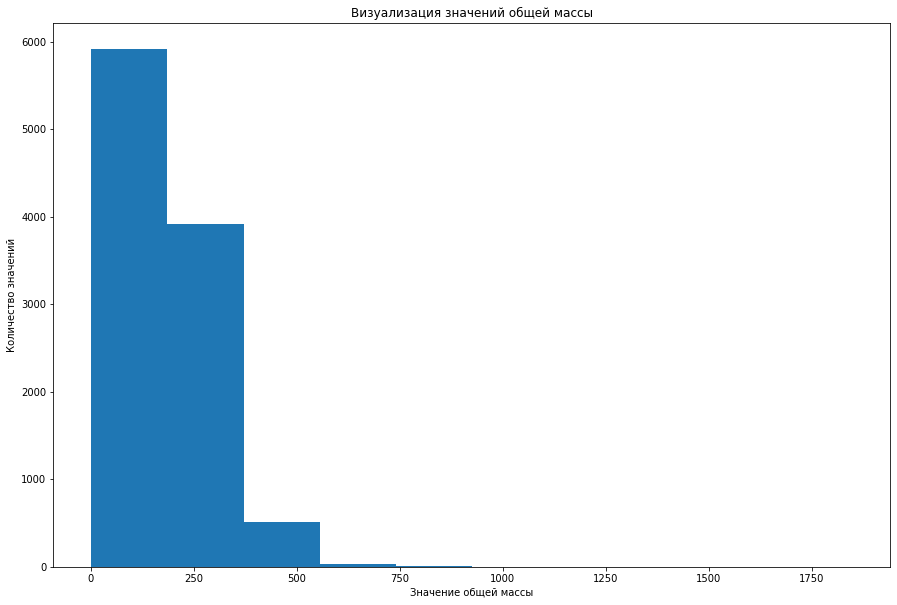

In [25]:
#Построим гистограмму
plt.subplots(figsize=(15, 10))
plt.hist(data_bulk_good['value'], bins=10)
plt.title('Визуализация значений общей массы')
plt.xlabel('Значение общей массы')
plt.ylabel('Количество значений')
plt.show()

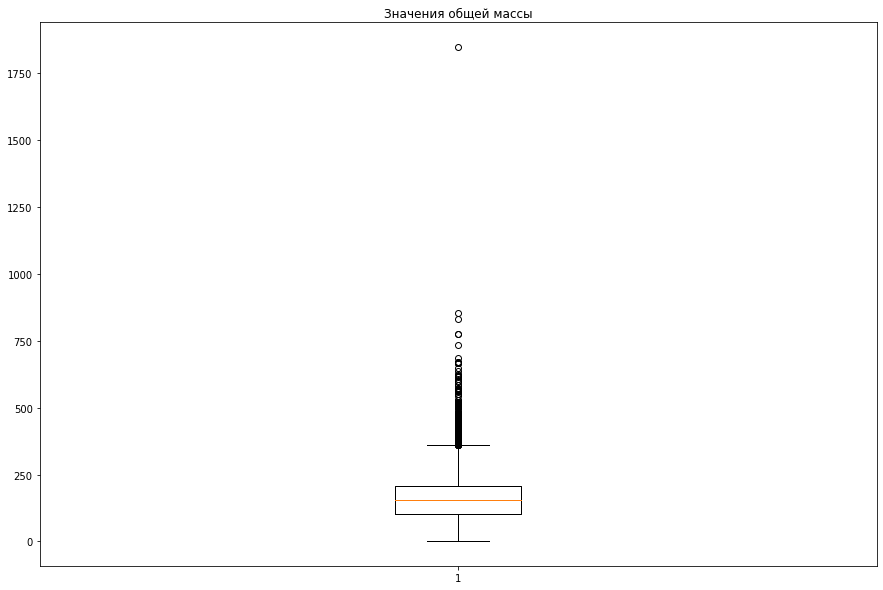

In [26]:
#Построим 'ящик с усами'
fig, axs = plt.subplots(figsize=(15, 10))
axs.boxplot(data_bulk_good['value'])
axs.set_title('Значения общей массы')
plt.show()

In [27]:
#Избавимся от выброса
data_bulk_good = data_bulk_good.query('value < 1750')

In [28]:
#Проверим изменения
all_info(data_bulk_good)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10391 entries, 0 to 10391
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       10391 non-null  int64         
 1   variable  10391 non-null  object        
 2   datetime  10391 non-null  datetime64[ns]
 3   value     10391 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 405.9+ KB


,key,variable,datetime,value
0,1,bulk_4,2019-05-03 11:21:30,43
1,1,bulk_12,2019-05-03 11:03:52,206
2,1,bulk_14,2019-05-03 11:03:52,150
3,1,bulk_15,2019-05-03 11:03:52,154
4,2,bulk_4,2019-05-03 11:46:38,73


,key,value
count,10391.000000,10391.000000
mean,1635.507458,172.950630
std,939.224809,95.049866
min,1.000000,1.000000
25%,820.500000,104.000000
50%,1636.000000,155.000000
75%,2454.000000,207.000000
max,3241.000000,853.000000


Количество пропусков:


key         0
variable    0
datetime    0
value       0
dtype: int64


Количество дубликатов: 0


### Вывод

В этих 2 файлах данные в ужасном состоянии, очень много пропусков в столбцах, что может сказаться при обучении моделей, поэтому  были сделаны следующие изменения:
- для анализа взяты данные, которые не имели много пропусков;
- удалён выброс;
- названия столбцов приведены к стилистически правильному виду;
- изменены типы данных с датами и значениями на более корректные;

### Данные о продувке сплава газом

In [29]:
#Изучим датафрейм
all_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество пропусков:


key      0
Газ 1    0
dtype: int64


Количество дубликатов: 0


In [30]:
#Переименуем столбцы
data_gas.columns = ['key', 'gas']

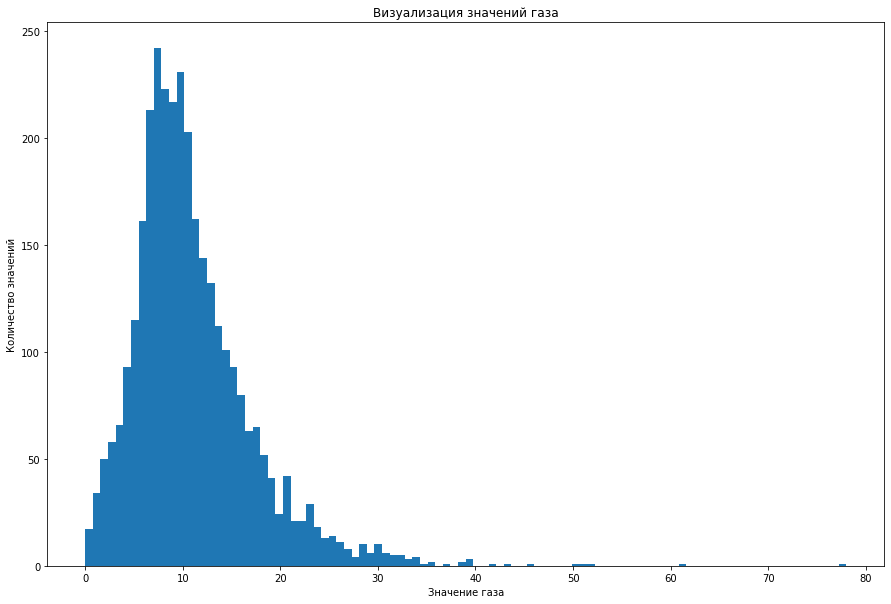

In [31]:
#Построим гистограмму
plt.subplots(figsize=(15, 10))
plt.hist(data_gas['gas'], bins=100)
plt.title('Визуализация значений газа')
plt.xlabel('Значение газа')
plt.ylabel('Количество значений')
plt.show()

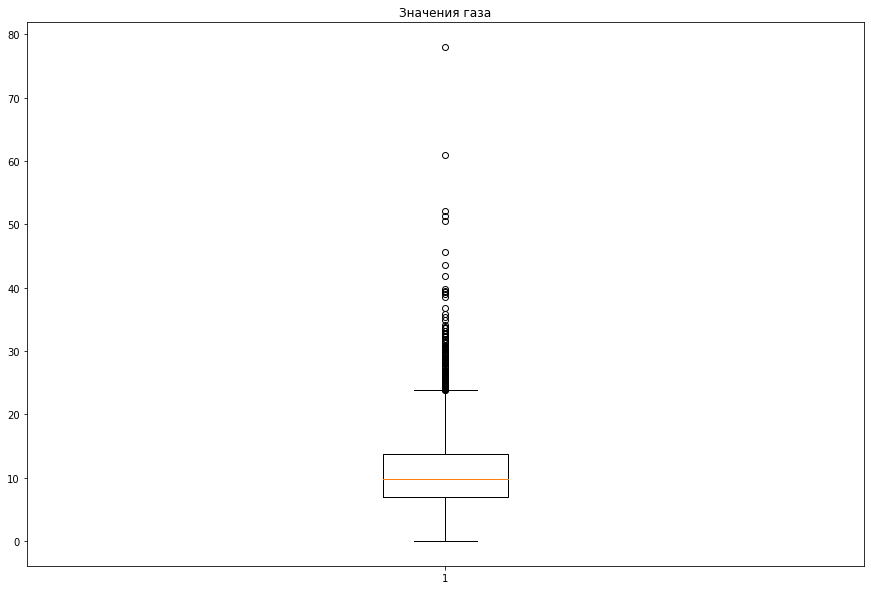

In [32]:
#Построим 'ящик с усами'
fig, axs = plt.subplots(figsize=(15, 10))
axs.boxplot(data_gas['gas'])
axs.set_title('Значения газа')
plt.show()

In [33]:
#Избавимся от выброса и проверим изменения
data_gas_good = data_gas.query('gas < 70')
all_info(data_gas_good)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3238 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3238 non-null   int64  
 1   gas     3238 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.9 KB


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,gas
count,3238.000000,3238.000000
mean,1622.262817,10.981372
std,935.251705,6.108806
min,1.000000,0.008399
25%,813.250000,7.042678
50%,1622.500000,9.832531
75%,2431.750000,13.767791
max,3241.000000,60.935689


Количество пропусков:


key    0
gas    0
dtype: int64


Количество дубликатов: 0


### Вывод

С данными по большей части всё в порядке, но произошли небольшие изменения:

- название столбца приведено к стилистически правильному виду;
- удалён выброс;

### Результаты измерения температуры

In [34]:
#Изучим датафрейм
all_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество пропусков:


key                0
Время замера       0
Температура     2901
dtype: int64


Количество дубликатов: 0


In [35]:
#Переименуем столбцы и приведём столбец с датами к корректному формату
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

In [36]:
#Посмотрим, сколько непустых значений находятся в ключах
data_temp_grouped = data_temp.groupby('key').count()
data_temp_grouped

,measurement_time,temperature
key,,
1,5,5
2,6,6
3,5,5
4,3,3
5,2,2
...,...,...
3237,5,1
3238,3,1
3239,8,1


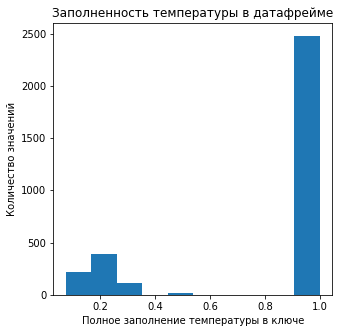

In [37]:
#Визуализируем полученные данные
data_temp_grouped['filling'] = data_temp_grouped['temperature'] / data_temp_grouped['measurement_time']
plt.figure(figsize=(5, 5))
plt.hist(data_temp_grouped['filling'], bins=10)
plt.title('Заполненность температуры в датафрейме')
plt.xlabel('Полное заполнение температуры в ключе')
plt.ylabel('Количество значений')
plt.show()

In [38]:
#Посмотрим количество частично или полностью пустых и непустых ключей
print('Количество полностью заполненных ключей:', len(data_temp_grouped[data_temp_grouped['filling'] == 1]))
print('Количество ключей с пропусками:', len(data_temp_grouped[data_temp_grouped['filling'] < 1]))

Количество полностью заполненных ключей: 2477
Количество ключей с пропусками: 739


In [39]:
#Удалим ключи, которые имеют хотя бы 1 пропуск и оставим только ключи с полностью заполненными значениями температуры
data_temp_good = data_temp[data_temp['key'].isin(data_temp_grouped.query('filling == 1').index)]
data_temp_good

,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


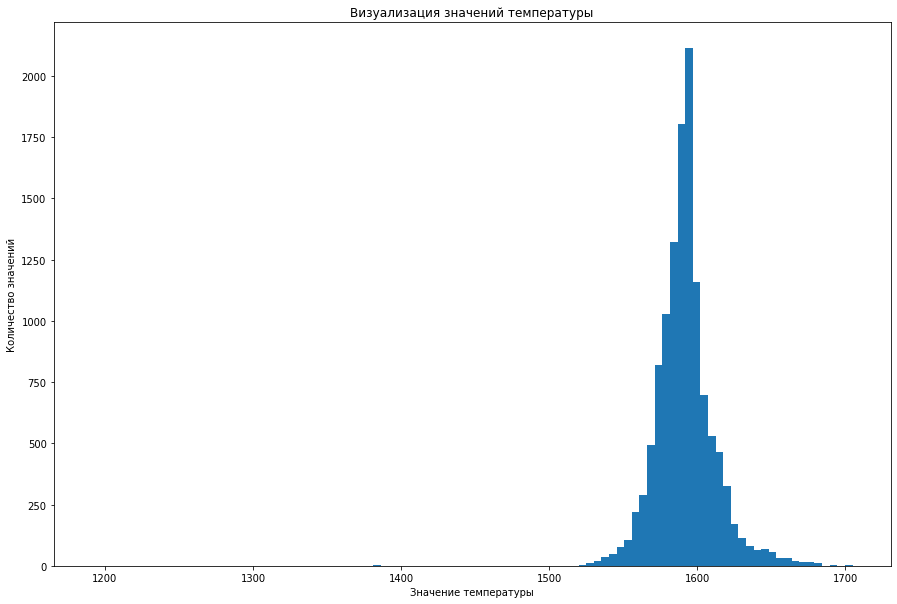

In [40]:
#Построим гистограмму
plt.subplots(figsize=(15, 10))
plt.hist(data_temp_good['temperature'], bins=100)
plt.title('Визуализация значений температуры')
plt.xlabel('Значение температуры')
plt.ylabel('Количество значений')
plt.show()

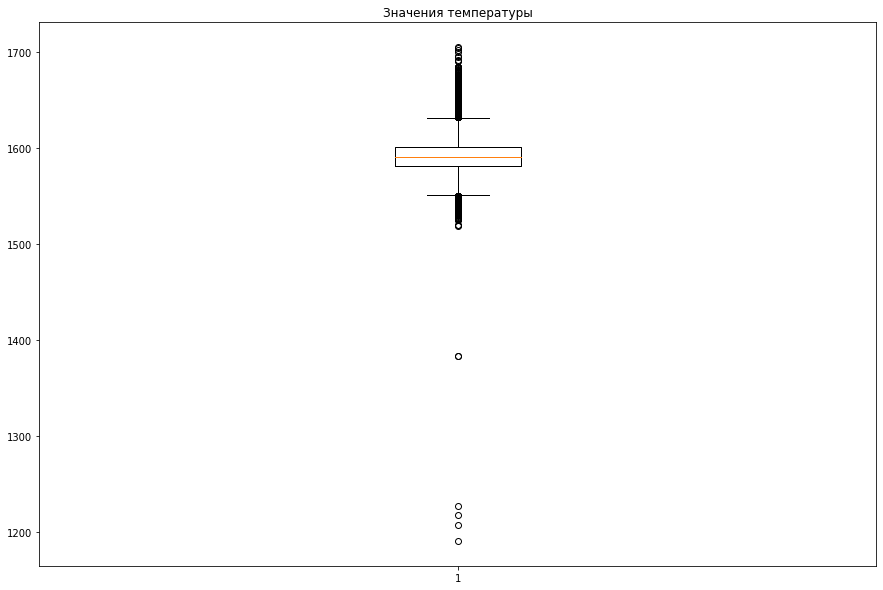

In [41]:
#Построим 'ящик с усами'
fig, axs = plt.subplots(figsize=(15, 10))
axs.boxplot(data_temp_good['temperature'])
axs.set_title('Значения температуры')
plt.show()

In [42]:
data_temp_good['temperature'] = data_temp_good['temperature'].astype('int')

In [43]:
#Проверим изменения
all_info(data_temp_good)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               12267 non-null  int64         
 1   measurement_time  12267 non-null  datetime64[ns]
 2   temperature       12267 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 383.3 KB


,key,measurement_time,temperature
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613


,key,temperature
count,12267.000000,12267.000000
mean,1235.589060,1591.999022
std,729.452481,20.833175
min,1.000000,1191.000000
25%,602.000000,1581.000000
50%,1238.000000,1591.000000
75%,1874.000000,1601.000000
max,2499.000000,1705.000000


Количество пропусков:


key                 0
measurement_time    0
temperature         0
dtype: int64


Количество дубликатов: 0


### Вывод

Данные в плохом состоянии, очень много пропусков в столбце с температурой, что может сказаться при обучении моделей, также есть выбросы, но скорее всего они оправданы, поэтому были сделаны следующие изменения:

- для анализа взяты данные с ключами, которые не имели ни одного пропуска;
- названия столбцов приведены к стилистически правильному виду;
- изменены типы данных с датами и температурами на более корректные;

### Данные о проволочных материалах

In [44]:
#Изучим датафрейм
all_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Количество дубликатов: 0


In [45]:
#Изучим датафрейм с датами
all_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Количество дубликатов: 0


In [46]:
#Переименуем столбцы
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
data_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [47]:
#Посмотрим количество непустых значений в столбцах
data_wire.count().sort_values(ascending=False)

key       3081
wire_1    3055
wire_2    1079
wire_6      73
wire_3      63
wire_9      29
wire_8      19
wire_4      14
wire_7      11
wire_5       1
dtype: int64

In [48]:
#Удалим столбцы, которые имеют много пропусков
data_wire_new = data_wire.drop(columns=['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis=1)
data_wire_time_new = data_wire_time.drop(columns=['wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], 
                                         axis=1)

In [49]:
#Применим функцию, которая использовалась для датафрейма с сыпучими материалами
data_wire_good = function(data_wire_new, data_wire_time_new)
data_wire_good

,key,variable,datetime,value
0,1,wire_1,2019-05-03 11:11:41,60.059998
1,2,wire_1,2019-05-03 11:46:10,96.052315
2,3,wire_1,2019-05-03 12:13:47,91.160157
3,4,wire_1,2019-05-03 12:48:05,89.063515
4,5,wire_1,2019-05-03 13:18:15,89.238236
...,...,...,...,...
4129,3237,wire_1,2019-08-31 22:50:20,38.088959
4130,3238,wire_1,2019-08-31 23:38:24,56.128799
4131,3239,wire_1,2019-09-01 01:50:43,143.357761
4132,3240,wire_1,2019-09-01 03:12:02,34.070400


In [50]:
#Приведём столбец с датами к корректному формату
data_wire_good['datetime'] = pd.to_datetime(data_wire_good['datetime'])

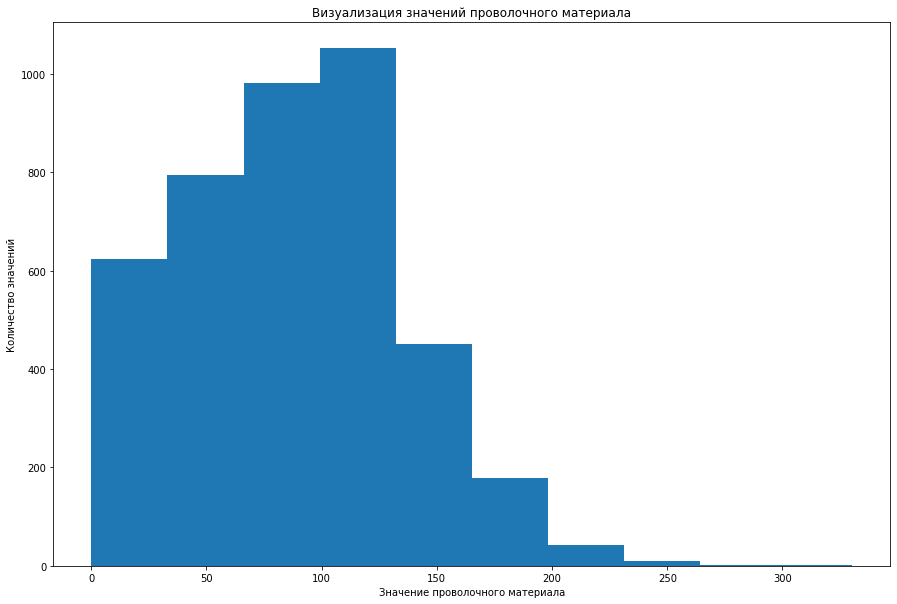

In [51]:
#Построим гистограмму
plt.subplots(figsize=(15, 10))
plt.hist(data_wire_good['value'], bins=10)
plt.title('Визуализация значений проволочного материала')
plt.xlabel('Значение проволочного материала')
plt.ylabel('Количество значений')
plt.show()

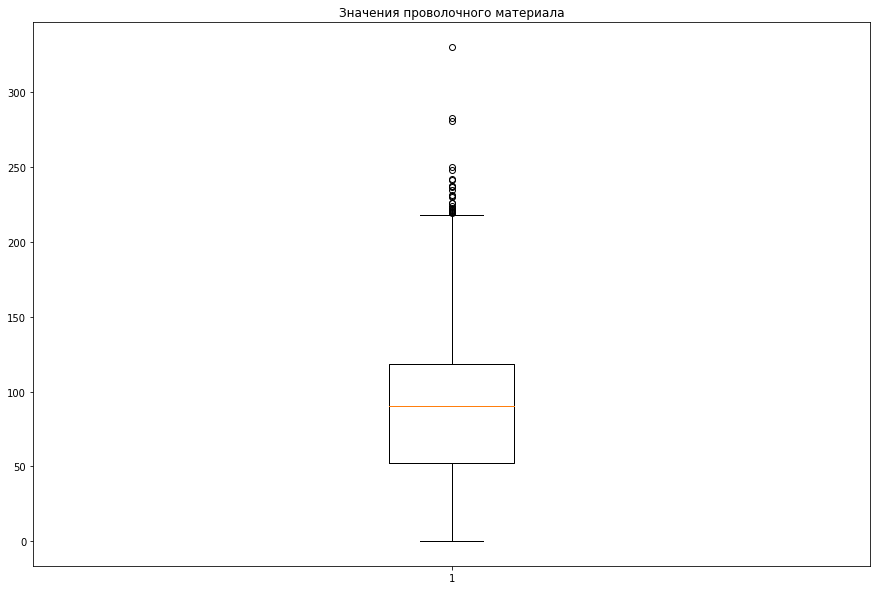

In [52]:
#Построим 'ящик с усами'
fig, axs = plt.subplots(figsize=(15, 10))
axs.boxplot(data_wire_good['value'])
axs.set_title('Значения проволочного материала')
plt.show()

In [53]:
#Удалим 1 выброс
data_wire_good = data_wire_good.query('value < 300')

In [54]:
#Проверим изменения
all_info(data_wire_good)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4133 entries, 0 to 4133
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       4133 non-null   int64         
 1   variable  4133 non-null   object        
 2   datetime  4133 non-null   datetime64[ns]
 3   value     4133 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 161.4+ KB


,key,variable,datetime,value
0,1,wire_1,2019-05-03 11:11:41,60.059998
1,2,wire_1,2019-05-03 11:46:10,96.052315
2,3,wire_1,2019-05-03 12:13:47,91.160157
3,4,wire_1,2019-05-03 12:48:05,89.063515
4,5,wire_1,2019-05-03 13:18:15,89.238236


,key,value
count,4133.000000,4133.000000
mean,1634.339463,87.703713
std,931.709010,46.714957
min,1.000000,0.030160
25%,834.000000,52.066559
50%,1641.000000,90.068153
75%,2444.000000,118.357200
max,3241.000000,282.780152


Количество пропусков:


key         0
variable    0
datetime    0
value       0
dtype: int64


Количество дубликатов: 0


### Вывод

В этих 2 файлах, как в прошлых 2 файлах с сыпучими материалами, данные в ужасном состоянии, очень много пропусков в столбцах, что может сказаться при обучении моделей, поэтому были сделаны следующие изменения:

- для анализа взяты данные, которые не имели много пропусков;
- удалён выброс;
- названия столбцов приведены к стилистически правильному виду;
- изменён тип данных с датами на более корректный;

### Изучения порядка действий

In [55]:
#Изучим все датафреймы с 1ым ключом
for df in [data_arc, data_bulk_good, data_gas, data_temp_good, data_wire_good]:
    print(df.query('key == 1'))
    print('\n')

   key   start_arc_heating     end_arc_heating  active_power  reactive_power
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.976059        0.687084
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.805607        0.520285
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.744363        0.498805
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      1.659363        1.062669
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.692755        0.414397


   key variable            datetime  value
0    1   bulk_4 2019-05-03 11:21:30     43
1    1  bulk_12 2019-05-03 11:03:52    206
2    1  bulk_14 2019-05-03 11:03:52    150
3    1  bulk_15 2019-05-03 11:03:52    154


   key        gas
0    1  29.749986


   key    measurement_time  temperature
0    1 2019-05-03 11:16:18         1571
1    1 2019-05-03 11:25:53         1604
2    1 2019-05-03 11:29:11         1618
3    1 2019-05-03 11:30:01         1601
4    1 2019-05-03 11:30:39         1613


   key variable            datetime    

**Судя по времени, можно выстроить следующую последовательность действий:**

1. Начало нагрева дугой 1 (11:02:14)
2. Подача сыпучих материалов bulk_12 (11:03:52)
3. Подача сыпучих материалов bulk_14 (11:03:52)
4. Подача сыпучих материалов bulk_15 (11:03:52)
5. Конец нагрева дугой 1 (11:06:02)
6. Начало нагрева дугой 2 (11:07:28)
7. Конец нагрева дугой 2 (11:10:33)
8. Подача проволочных материалов wire_1 (11:11:41)
9. Начало нагрева дугой 3 (11:11:44)
10. Конец нагрева дугой 3 (11:14:36)
11. Замер температуры 1 (11:16:18)
11. Начало нагрева дугой 4 (11:18:14)
12. Подача сыпучих материалов bulk_4 (11:21:30)
13. Конец нагрева дугой 4 (11:24:19)
14. Замер температуры 2 (11:25:53)
15. Начало нагрева дугой 5 (11:26:09)
16. Конец нагрева дугой 5 (11:28:37)
17. Замер температуры 3 (11:29:11)
18. Замер температуры 4 (11:30:01)
19. Замер температуры 5 (11:30:39)

### Вывод

Был произведён анализ действий с данными по первому ключу, что возможно пригодится в дальнейшем при выявлении признаков и обучении моделей.

## Подготовка данных

In [56]:
#Рассчитаем суммарную и среднюю активную и реактивную мощности
data_arc_pivot_table = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'], aggfunc={np.sum, np.mean})
data_arc_pivot_table.columns = ['mean_active_power', 'sum_active_power', 'mean_reactive_power', 'sum_reactive_power']
data_arc_pivot_table = data_arc_pivot_table.reindex(columns=['sum_active_power', 'sum_reactive_power', 'mean_active_power',
                                                             'mean_reactive_power'])
data_arc_pivot_table

,sum_active_power,sum_reactive_power,mean_active_power,mean_reactive_power
key,,,,
1,4.878147,3.183241,0.975629,0.636648
2,3.052598,1.998112,0.763150,0.499528
3,2.525882,1.599076,0.505176,0.319815
4,3.209250,2.060298,0.802313,0.515074
5,3.347173,2.252643,0.836793,0.563161
...,...,...,...,...
3237,3.932467,2.828459,0.786493,0.565692
3238,2.106529,1.681182,0.702176,0.560394
3239,4.666754,3.111617,0.583344,0.388952


In [57]:
#Найдём минимальную, максимальную и среднюю температуры в каждом ключе
data_temp_pivot_table = data_temp_good.pivot_table(index='key', values='temperature', 
                                                   aggfunc={np.min, np.max, np.mean})
data_temp_pivot_table.columns = ['max_temperature', 'min_temperature', 'mean_temperature']
data_temp_pivot_table

,max_temperature,min_temperature,mean_temperature
key,,,
1,1618.0,1571.0,1601.400000
2,1608.0,1577.0,1593.500000
3,1599.0,1596.0,1597.800000
4,1625.0,1601.0,1616.333333
5,1602.0,1576.0,1589.000000
...,...,...,...
2495,1591.0,1570.0,1583.666667
2496,1595.0,1554.0,1579.000000
2497,1589.0,1571.0,1580.000000


In [58]:
#Выведем максимальное и минимальное время замера температуры для каждого ключа
data_temp_time_pivot_table = data_temp_good.pivot_table(index='key', values='measurement_time', aggfunc={np.min, np.max})
data_temp_time_pivot_table.columns = ['max_time', 'min_time']
data_temp_time_pivot_table

,max_time,min_time
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


In [59]:
#Создадим новый датафрейм с первым и последним значением замеров температуры для каждого ключа в зависимости от времени
data_temp_time_first = list(data_temp_time_pivot_table['min_time'])
data_temp_time_last = list(data_temp_time_pivot_table['max_time'])
data_temp_first = data_temp_good.query('measurement_time in @data_temp_time_first')
data_temp_last = data_temp_good.query('measurement_time in @data_temp_time_last')
data_temp_first_and_last = data_temp_first.merge(data_temp_last, on='key')
data_temp_first_and_last = data_temp_first_and_last.drop(['measurement_time_x', 'measurement_time_y'], axis=1)
data_temp_first_and_last.columns = ['key', 'first_time_temperature', 'last_time_temperature']
data_temp_first_and_last

,key,first_time_temperature,last_time_temperature
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599
3,4,1601,1625
4,5,1576,1602
...,...,...,...
2472,2495,1570,1591
2473,2496,1554,1591
2474,2497,1571,1589
2475,2498,1591,1594


In [60]:
#Изучим ключи, где первое и последнее значение температуры от замера совпадают
data_temp_first_and_last[
    data_temp_first_and_last['first_time_temperature'] == data_temp_first_and_last['last_time_temperature']]

,key,first_time_temperature,last_time_temperature
60,63,1580,1580
192,195,1583,1583
194,197,1582,1582
259,262,1596,1596
276,279,1603,1603
484,489,1593,1593
565,573,1575,1575
578,586,1594,1594
614,623,1597,1597
623,632,1579,1579


In [61]:
#Уберём эти значения
data_temp_first_and_last = data_temp_first_and_last.query('first_time_temperature != last_time_temperature')

In [62]:
data_temp_final = data_temp_first_and_last.merge(data_temp_pivot_table, on='key')
data_temp_final

,key,first_time_temperature,last_time_temperature,max_temperature,min_temperature,mean_temperature
0,1,1571,1613,1618.0,1571.0,1601.400000
1,2,1581,1602,1608.0,1577.0,1593.500000
2,3,1596,1599,1599.0,1596.0,1597.800000
3,4,1601,1625,1625.0,1601.0,1616.333333
4,5,1576,1602,1602.0,1576.0,1589.000000
...,...,...,...,...,...,...
2428,2495,1570,1591,1591.0,1570.0,1583.666667
2429,2496,1554,1591,1595.0,1554.0,1579.000000
2430,2497,1571,1589,1589.0,1571.0,1580.000000
2431,2498,1591,1594,1594.0,1570.0,1585.600000


In [63]:
#Объединим все датафреймы в итоговый для подготовки признаков
data_merge_1 = data_temp_final.merge(data_arc_pivot_table, on='key')
data_merge_2 = data_merge_1.merge(data_gas, on='key')
data_merge_3 = data_merge_2.merge(data_bulk_new, on='key')
data_final = data_merge_3.merge(data_wire_new, on='key')
data_final

,key,first_time_temperature,last_time_temperature,max_temperature,min_temperature,mean_temperature,sum_active_power,sum_reactive_power,mean_active_power,mean_reactive_power,gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,1571,1613,1618.0,1571.0,1601.400000,4.878147,3.183241,0.975629,0.636648,29.749986,NaN,43.0,NaN,206.0,150.0,154.0,60.059998,NaN
1,2,1581,1602,1608.0,1577.0,1593.500000,3.052598,1.998112,0.763150,0.499528,12.555561,NaN,73.0,NaN,206.0,149.0,154.0,96.052315,NaN
2,3,1596,1599,1599.0,1596.0,1597.800000,2.525882,1.599076,0.505176,0.319815,28.554793,NaN,34.0,NaN,205.0,152.0,153.0,91.160157,NaN
3,4,1601,1625,1625.0,1601.0,1616.333333,3.209250,2.060298,0.802313,0.515074,18.841219,NaN,81.0,NaN,207.0,153.0,154.0,89.063515,NaN
4,5,1576,1602,1602.0,1576.0,1589.000000,3.347173,2.252643,0.836793,0.563161,5.413692,NaN,78.0,NaN,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,2495,1570,1591,1591.0,1570.0,1583.666667,3.210690,2.360777,0.802673,0.590194,7.125735,21.0,NaN,NaN,256.0,129.0,223.0,89.150879,NaN
2289,2496,1554,1591,1595.0,1554.0,1579.000000,4.203064,2.810185,0.700511,0.468364,9.412616,NaN,63.0,NaN,256.0,129.0,226.0,114.179527,NaN
2290,2497,1571,1589,1589.0,1571.0,1580.000000,2.212379,1.851269,0.737460,0.617090,6.271699,NaN,85.0,NaN,230.0,124.0,226.0,94.086723,9.04800
2291,2498,1591,1594,1594.0,1570.0,1585.600000,3.408725,2.355428,0.681745,0.471086,14.953657,90.0,NaN,NaN,206.0,129.0,207.0,118.110717,NaN


In [64]:
#Заполним все пропуски нулями и поменяем тип данных на 'int'
for value in data_final[['bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 
                         'max_temperature', 'min_temperature']]:
    data_final[value] = data_final[value].fillna(0)
    data_final[value] = data_final[value].astype('int')

In [65]:
#Проверим изменения
all_info(data_final)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2293 non-null   int64  
 1   first_time_temperature  2293 non-null   int64  
 2   last_time_temperature   2293 non-null   int64  
 3   max_temperature         2293 non-null   int64  
 4   min_temperature         2293 non-null   int64  
 5   mean_temperature        2293 non-null   float64
 6   sum_active_power        2293 non-null   float64
 7   sum_reactive_power      2293 non-null   float64
 8   mean_active_power       2293 non-null   float64
 9   mean_reactive_power     2293 non-null   float64
 10  gas                     2293 non-null   float64
 11  bulk_3                  2293 non-null   int64  
 12  bulk_4                  2293 non-null   int64  
 13  bulk_6                  2293 non-null   int64  
 14  bulk_12                 2293 non-null   

,key,first_time_temperature,last_time_temperature,max_temperature,min_temperature,mean_temperature,sum_active_power,sum_reactive_power,mean_active_power,mean_reactive_power,gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,1571,1613,1618,1571,1601.400000,4.878147,3.183241,0.975629,0.636648,29.749986,0,43,0,206,150,154,60,0
1,2,1581,1602,1608,1577,1593.500000,3.052598,1.998112,0.763150,0.499528,12.555561,0,73,0,206,149,154,96,0
2,3,1596,1599,1599,1596,1597.800000,2.525882,1.599076,0.505176,0.319815,28.554793,0,34,0,205,152,153,91,0
3,4,1601,1625,1625,1601,1616.333333,3.209250,2.060298,0.802313,0.515074,18.841219,0,81,0,207,153,154,89,0
4,5,1576,1602,1602,1576,1589.000000,3.347173,2.252643,0.836793,0.563161,5.413692,0,78,0,203,151,152,89,9


,key,first_time_temperature,last_time_temperature,max_temperature,min_temperature,mean_temperature,sum_active_power,sum_reactive_power,mean_active_power,mean_reactive_power,gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1249.383777,1586.618404,1593.369385,1601.529001,1576.191016,1589.511353,3.159834,2.355730,0.670130,0.499836,11.398265,47.646315,37.163977,22.575665,208.696031,154.081989,120.134758,102.218927,17.638029
std,715.286078,28.457503,11.179055,15.347279,21.896974,12.838597,1.427087,1.082971,0.197663,0.147850,6.400106,75.544868,58.649208,56.076153,157.246962,81.571328,84.726913,43.603581,33.702227
min,1.000000,1191.000000,1541.000000,1558.000000,1191.000000,1518.400000,0.186226,0.158247,0.186226,0.130062,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,627.000000,1571.000000,1587.000000,1591.000000,1568.000000,1581.375000,2.190623,1.628309,0.526430,0.392378,7.303306,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.000000,0.000000
50%,1251.000000,1586.000000,1593.000000,1599.000000,1579.000000,1589.400000,3.034115,2.240437,0.646811,0.488201,10.108007,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.000000,0.000000
75%,1865.000000,1603.000000,1598.000000,1611.000000,1588.000000,1597.500000,3.928126,2.924655,0.793820,0.593292,14.221584,80.000000,77.000000,0.000000,281.000000,204.000000,204.000000,128.000000,23.000000
max,2499.000000,1660.000000,1653.000000,1662.000000,1629.000000,1646.000000,17.496497,12.587990,1.421416,1.134983,77.995040,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,330.000000,282.000000


Количество пропусков:


key                       0
first_time_temperature    0
last_time_temperature     0
max_temperature           0
min_temperature           0
mean_temperature          0
sum_active_power          0
sum_reactive_power        0
mean_active_power         0
mean_reactive_power       0
gas                       0
bulk_3                    0
bulk_4                    0
bulk_6                    0
bulk_12                   0
bulk_14                   0
bulk_15                   0
wire_1                    0
wire_2                    0
dtype: int64


Количество дубликатов: 0


In [66]:
#Поскольку в исследовательском анализе данных были удалены по 1 выбросу для столбцов, то заменим их 0 в финальном датафрейме
data_final.loc[data_final['gas'] == data_final.loc[:, 'gas'].max(), 'gas'] = 0
data_final.loc[data_final['wire_1'] == data_final.loc[:, 'wire_1'].max(), 'wire_1'] = 0
data_final.loc[data_final['bulk_12'] == data_final.loc[:, 'bulk_12'].max(), 'bulk_12'] = 0

In [67]:
#Проверим изменения
all_info(data_final)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2293 non-null   int64  
 1   first_time_temperature  2293 non-null   int64  
 2   last_time_temperature   2293 non-null   int64  
 3   max_temperature         2293 non-null   int64  
 4   min_temperature         2293 non-null   int64  
 5   mean_temperature        2293 non-null   float64
 6   sum_active_power        2293 non-null   float64
 7   sum_reactive_power      2293 non-null   float64
 8   mean_active_power       2293 non-null   float64
 9   mean_reactive_power     2293 non-null   float64
 10  gas                     2293 non-null   float64
 11  bulk_3                  2293 non-null   int64  
 12  bulk_4                  2293 non-null   int64  
 13  bulk_6                  2293 non-null   int64  
 14  bulk_12                 2293 non-null   

,key,first_time_temperature,last_time_temperature,max_temperature,min_temperature,mean_temperature,sum_active_power,sum_reactive_power,mean_active_power,mean_reactive_power,gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,1571,1613,1618,1571,1601.400000,4.878147,3.183241,0.975629,0.636648,29.749986,0,43,0,206,150,154,60,0
1,2,1581,1602,1608,1577,1593.500000,3.052598,1.998112,0.763150,0.499528,12.555561,0,73,0,206,149,154,96,0
2,3,1596,1599,1599,1596,1597.800000,2.525882,1.599076,0.505176,0.319815,28.554793,0,34,0,205,152,153,91,0
3,4,1601,1625,1625,1601,1616.333333,3.209250,2.060298,0.802313,0.515074,18.841219,0,81,0,207,153,154,89,0
4,5,1576,1602,1602,1576,1589.000000,3.347173,2.252643,0.836793,0.563161,5.413692,0,78,0,203,151,152,89,9


,key,first_time_temperature,last_time_temperature,max_temperature,min_temperature,mean_temperature,sum_active_power,sum_reactive_power,mean_active_power,mean_reactive_power,gas,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1249.383777,1586.618404,1593.369385,1601.529001,1576.191016,1589.511353,3.159834,2.355730,0.670130,0.499836,11.364250,47.646315,37.163977,22.575665,207.889664,154.081989,120.134758,102.075011,17.638029
std,715.286078,28.457503,11.179055,15.347279,21.896974,12.838597,1.427087,1.082971,0.197663,0.147850,6.251546,75.544868,58.649208,56.076153,153.528665,81.571328,84.726913,43.395544,33.702227
min,1.000000,1191.000000,1541.000000,1558.000000,1191.000000,1518.400000,0.186226,0.158247,0.186226,0.130062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,627.000000,1571.000000,1587.000000,1591.000000,1568.000000,1581.375000,2.190623,1.628309,0.526430,0.392378,7.299764,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.000000,0.000000
50%,1251.000000,1586.000000,1593.000000,1599.000000,1579.000000,1589.400000,3.034115,2.240437,0.646811,0.488201,10.105480,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.000000,0.000000
75%,1865.000000,1603.000000,1598.000000,1611.000000,1588.000000,1597.500000,3.928126,2.924655,0.793820,0.593292,14.220873,80.000000,77.000000,0.000000,281.000000,204.000000,204.000000,127.000000,23.000000
max,2499.000000,1660.000000,1653.000000,1662.000000,1629.000000,1646.000000,17.496497,12.587990,1.421416,1.134983,60.935689,454.000000,281.000000,503.000000,853.000000,636.000000,405.000000,280.000000,282.000000


Количество пропусков:


key                       0
first_time_temperature    0
last_time_temperature     0
max_temperature           0
min_temperature           0
mean_temperature          0
sum_active_power          0
sum_reactive_power        0
mean_active_power         0
mean_reactive_power       0
gas                       0
bulk_3                    0
bulk_4                    0
bulk_6                    0
bulk_12                   0
bulk_14                   0
bulk_15                   0
wire_1                    0
wire_2                    0
dtype: int64


Количество дубликатов: 0


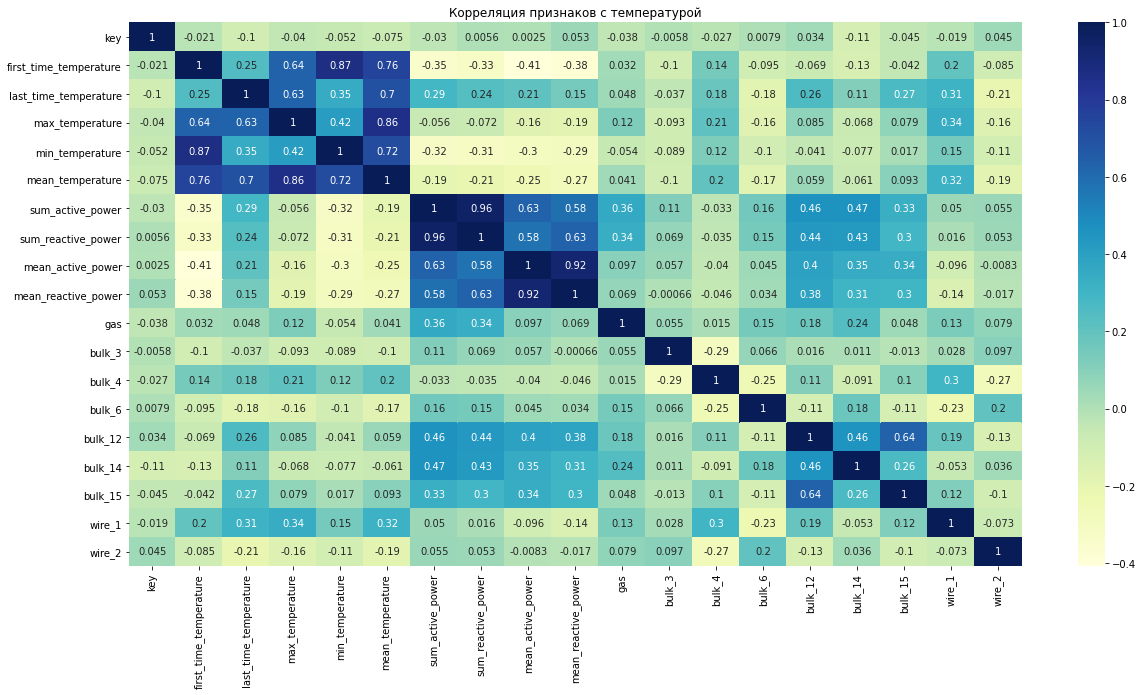

In [68]:
#Изучим мультиколлинеарность признаков
corr = data_final.corr()
plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title('Корреляция признаков с температурой')
plt.show()

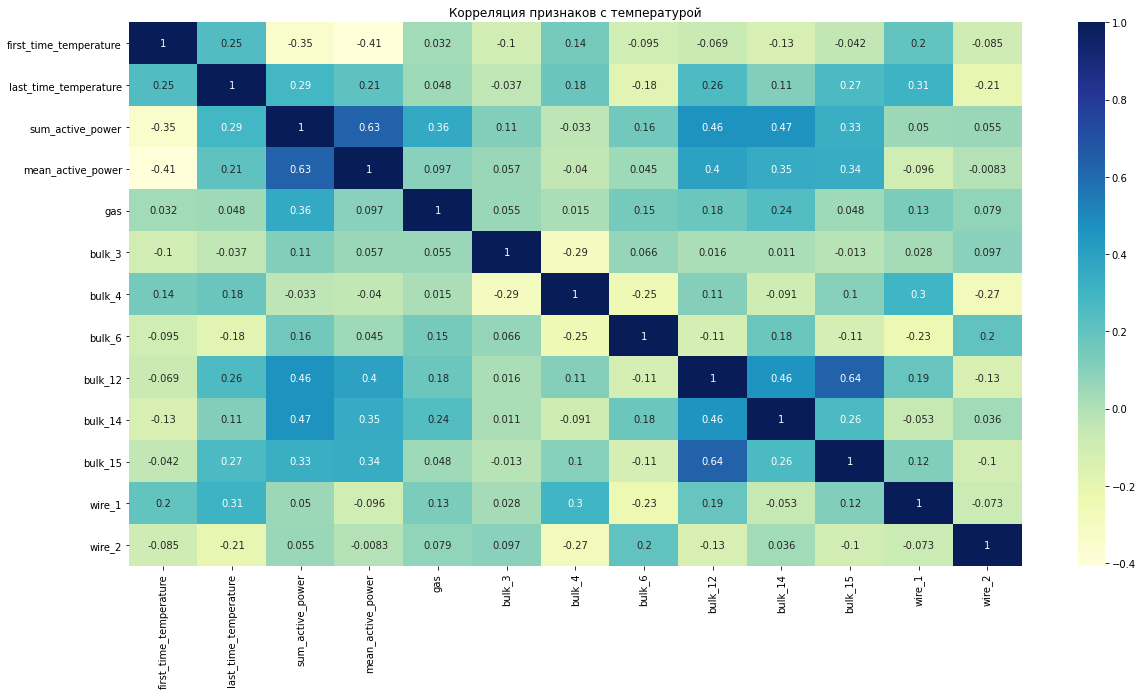

In [69]:
#Удалим ненужные столбцы, которые могут испортить качество модели
data_final_good = data_final.drop(['sum_reactive_power', 'mean_reactive_power','min_temperature', 'max_temperature',
                                   'mean_temperature', 'key'], axis=1)
corr = data_final_good.corr()
plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title('Корреляция признаков с температурой')
plt.show()

In [70]:
#Выделим признаки и разделим на обучающую и тестовую выборки
features = data_final_good.drop(['last_time_temperature'], axis=1)
target = data_final_good['last_time_temperature']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=42)

In [71]:
#Проведём масштамбирование признаков
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [72]:
#Изучим размер выборок
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (1719, 12)
Размер тестовой выборки: (574, 12)


### Вывод

Данные были подготовлены для обучения моделей, для них сделаны расчёты, ко которым затем создавались признаки. 

Признаки:

- first_time_temperature; (первый замер температуры ключа)     
- sum_active_power; (суммарная активная мощность ключа)         
- mean_active_power; (средняя активная мощность ключа)        
- gas; (значение газа)                     
- bulk_3; (значение сыпучего материала 3)                   
- bulk_4; (значение сыпучего материала 4)                   
- bulk_6; (значение сыпучего материала 6)                 
- bulk_12; (значение сыпучего материала 12)                  
- bulk_14; (значение сыпучего материала 14)                  
- bulk_15; (значение сыпучего материала 15)                  
- wire_1; (значение проволочного материала 1)                   
- wire_2; (значение проволочного материала 2)

Целевой признак: last_time_temperature (температура)

Остальные признаки были удалены вследствии слишком большой коллинеарности или не являлись необходимыми.

## Обучение моделей

В качестве моделей для обучения выберем: LGMBRegressor, LinearRegression, RandomForestRegressor, DecisionTreeRegressor, Neural networks. Также подберём лучшие параметры для каждой.

In [73]:
%%time
#Создадим LGBMRegressor
model_lgbm = LGBMRegressor()

CPU times: user 28 µs, sys: 4 µs, total: 32 µs
Wall time: 35 µs


In [74]:
%%time
#Создадим и подберём лучшие параметры для LinearRegression
parameters_lr = {'fit_intercept': [True, False],
                 'n_jobs': [-1, 0, 1],
                 'normalize': [True, False]}
model_lr = LinearRegression()
grid_lr = GridSearchCV(estimator=model_lr, param_grid=parameters_lr, scoring='neg_mean_absolute_error', cv=5)
grid_lr.fit(features_train, target_train)
best_parameters_lr = grid_lr.best_params_
print(best_parameters_lr)

{'fit_intercept': True, 'n_jobs': -1, 'normalize': True}
CPU times: user 317 ms, sys: 258 ms, total: 574 ms
Wall time: 557 ms


In [75]:
%%time
#Создадим и подберём лучшие параметры для RandomForestRegressor
parameters_rf = {'random_state': [42],
                 'max_depth': [5, 7, 10],
                 'n_estimators': [100, 500],
                 'max_features': ['sqrt', 'log2', None]}
model_rf = RandomForestRegressor()
grid_rf = GridSearchCV(estimator=model_rf, param_grid=parameters_rf, scoring='neg_mean_absolute_error', cv=5)
grid_rf.fit(features_train, target_train)

best_parameters_rf = grid_rf.best_params_
print(best_parameters_rf)

{'max_depth': 10, 'max_features': None, 'n_estimators': 100, 'random_state': 42}
CPU times: user 1min 28s, sys: 384 ms, total: 1min 29s
Wall time: 1min 30s


In [76]:
%%time
#Создадим и подберём лучшие параметры для DecisionTreeRegressor
parameters_dtr = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                  'splitter': ['best', 'random'],          
                  'random_state': [42],
                  'max_depth': [5, 7, 10],
                  'max_features': ['auto', 'sqrt', 'log2', None]}
model_dtr = DecisionTreeRegressor()
grid_dtr = GridSearchCV(estimator=model_dtr, param_grid=parameters_dtr, scoring='neg_mean_absolute_error', cv=5)
grid_dtr.fit(features_train, target_train)

best_parameters_dtr = grid_dtr.best_params_
print(best_parameters_dtr)

{'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'auto', 'random_state': 42, 'splitter': 'best'}
CPU times: user 1.43 s, sys: 11.8 ms, total: 1.45 s
Wall time: 1.46 s


In [77]:
#Создадим модель для Neural networks
model_keras = Sequential()
model_keras.add(Dense(10, input_dim=features_train.shape[1], activation='relu'))
model_keras.add(Dense(6, activation='relu'))
model_keras.add(Dense(6, activation='relu'))
model_keras.add(Dense(6, activation='relu'))
model_keras.add(Dense(6, activation='relu'))
model_keras.add(Dense(1, activation='linear'))
model_keras.compile(loss='mean_squared_error', metrics = ['mean_absolute_error'], optimizer='adam')

2022-07-24 10:40:27.379251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Вывод

Таким образом, лучшие параметры для каждой модели:
- LGBMRegressor: none
- LinearRegression: 'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
- RandomForestRegressor: 'max_depth': 10, 'max_features': None, 'n_estimators': 500, 'random_state': 42}
- DecisionTreeRegressor: 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'auto', 'random_state': 42, 'splitter': 'best'

## Тестирование моделей

**LinearRegression**

In [78]:
#Посмотрим средний MAE на обучающей выборке с кросс-валидацией
mae_lr_mean = cross_val_score(model_lr, 
                              features_train, 
                              target_train, 
                              cv=5,
                              n_jobs=-1,
                              scoring='neg_mean_absolute_error').mean() * -1
print('Среднее MAE на обучающей выборке:', mae_lr_mean)

Среднее MAE на обучающей выборке: 6.576168729920276


In [79]:
#Подставим лучшие параметры для LinearRegression и получим MAE на тестовой выборке
model_lr.set_params(**best_parameters_lr)
model_lr.fit(features_train, target_train)
expected_target = target_test
predicted_target = model_lr.predict(features_test)
mae_lr = mean_absolute_error(expected_target, predicted_target)
print('MAE на тестовой выборке:', mae_lr)

MAE на тестовой выборке: 6.497535433792827


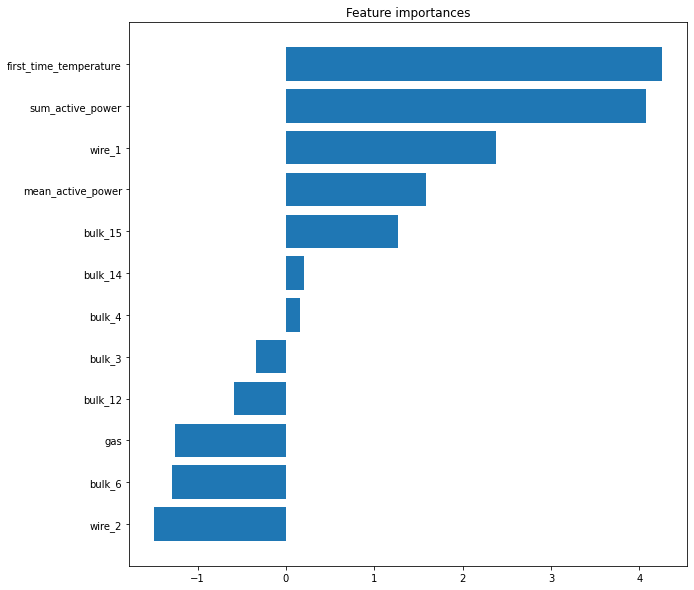

In [80]:
#Изучим влияние факторов на целевой признак для LinearRegression
importances_lr = model_lr.coef_
feature_names = ['first_time_temperature', 'sum_active_power', 'mean_active_power', 'gas', 'bulk_3', 'bulk_4',
                 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2']
indices_lr = np.argsort(importances_lr)
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.barh(range(features_train.shape[1]), importances_lr[indices_lr])
plt.yticks(range(features_train.shape[1]), [feature_names[i] for i in indices_lr])
plt.ylim([-1, features_train.shape[1]])
plt.show()

In [81]:
#Выведем в датафрейм полученные значения
df_lr = pd.DataFrame(data=np.sort(importances_lr), index=[feature_names[i] for i in indices_lr], columns=['coeffs'])
df_lr = df_lr[::-1]
df_lr

,coeffs
first_time_temperature,4.251896
sum_active_power,4.071144
wire_1,2.372335
mean_active_power,1.587243
bulk_15,1.274252
bulk_14,0.201066
bulk_4,0.163550
bulk_3,-0.335908
bulk_12,-0.581895
gas,-1.251324


**DecisionTreeRegressor**

In [82]:
#Посмотрим средний MAE на обучающей выборке с кросс-валидацией
mae_dtr_mean = cross_val_score(model_dtr, 
                               features_train, 
                               target_train, 
                               cv=5,
                               n_jobs=-1,
                               scoring='neg_mean_absolute_error').mean() * -1
print('Среднее MAE на обучающей выборке:', mae_dtr_mean)

Среднее MAE на обучающей выборке: 8.391626550952608


In [83]:
#Подставим лучшие параметры для DecisionTreeRegressor и получим MAE на тестовой выборке
model_dtr.set_params(**best_parameters_dtr)
model_dtr.fit(features_train, target_train)
expected_target = target_test
predicted_target = model_dtr.predict(features_test)
mae_dtr = mean_absolute_error(expected_target, predicted_target)
print('MAE на тестовой выборке:', mae_dtr)

MAE на тестовой выборке: 7.124436500936044


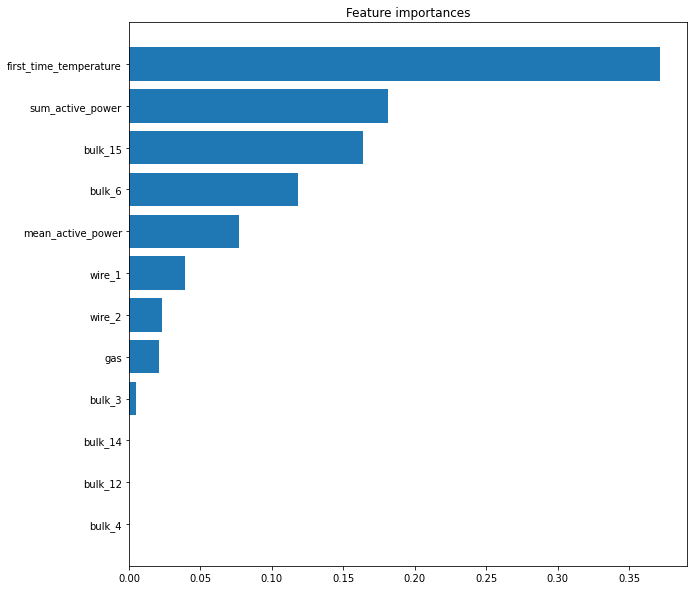

In [84]:
#Изучим влияние факторов на целевой признак для DecisionTreeRegressor
importances_dtr = model_dtr.feature_importances_
indices_dtr = np.argsort(importances_dtr)
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.barh(range(features_train.shape[1]), importances_dtr[indices_dtr])
plt.yticks(range(features_train.shape[1]), [feature_names[i] for i in indices_dtr])
plt.ylim([-1, features_train.shape[1]])
plt.show()

In [85]:
#Выведем в датафрейм полученные значения
df_dtr = pd.DataFrame(data=np.sort(importances_dtr), index=[feature_names[i] for i in indices_dtr], columns=['coeffs'])
df_dtr = df_dtr[::-1]
df_dtr

,coeffs
first_time_temperature,0.371818
sum_active_power,0.181348
bulk_15,0.163900
bulk_6,0.118212
mean_active_power,0.076976
wire_1,0.038948
wire_2,0.023140
gas,0.020798
bulk_3,0.004860
bulk_14,0.000000


**RandomForestRegressor**

In [86]:
#Посмотрим средний MAE на обучающей выборке с кросс-валидацией
mae_rf_mean = cross_val_score(model_rf, 
                              features_train, 
                              target_train, 
                              cv=5,
                              n_jobs=-1,
                              scoring='neg_mean_absolute_error').mean() * -1
print('Среднее MAE на обучающей выборке:', mae_rf_mean)

Среднее MAE на обучающей выборке: 6.120548647365924


In [87]:
#Подставим лучшие параметры для RandomForestRegressor и получим MAE на тестовой выборке
model_rf.set_params(**best_parameters_rf)
model_rf.fit(features_train, target_train)
expected_target = target_test
predicted_target = model_rf.predict(features_test)
mae_rf = mean_absolute_error(expected_target, predicted_target)
print('MAE на тестовой выборке:', mae_rf)

MAE на тестовой выборке: 5.905859082544626


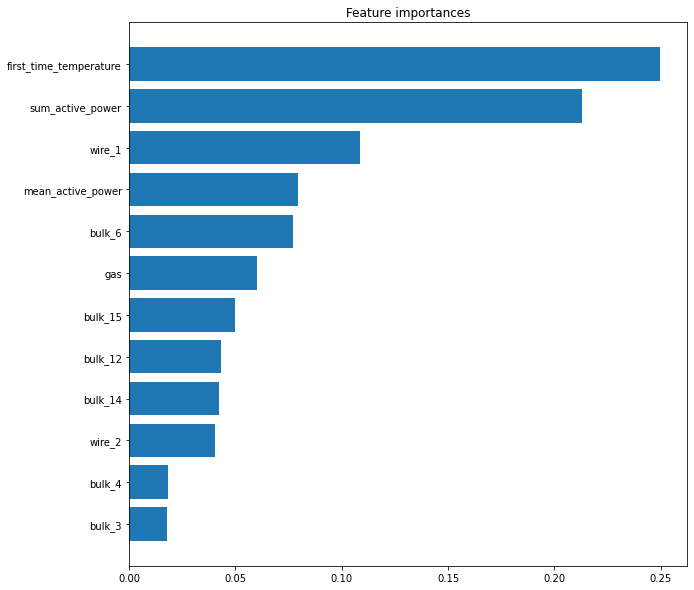

In [88]:
#Изучим влияние факторов на целевой признак для RandomForestRegressor
importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(importances_rf)
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.barh(range(features_train.shape[1]), importances_rf[indices_rf])
plt.yticks(range(features_train.shape[1]), [feature_names[i] for i in indices_rf])
plt.ylim([-1, features_train.shape[1]])
plt.show()

In [89]:
#Выведем в датафрейм полученные значения
df_rf = pd.DataFrame(data=np.sort(importances_rf), index=[feature_names[i] for i in indices_rf], columns=['coeffs'])
df_rf= df_rf[::-1]
df_rf

,coeffs
first_time_temperature,0.249842
sum_active_power,0.213108
wire_1,0.108414
mean_active_power,0.079348
bulk_6,0.077137
gas,0.060315
bulk_15,0.049731
bulk_12,0.043429
bulk_14,0.042270
wire_2,0.040353


**LGMBRegressor**

In [90]:
#Получим MAE для LGMBRegressor на тестовой выборке
model_lgbm.fit(features_train, target_train)
expected_target = target_test
predicted_target = model_lgbm.predict(features_test)
mae_lgbm = mean_absolute_error(expected_target, predicted_target)
print('MAE на тестовой выборке:', mae_lgbm)

MAE на тестовой выборке: 5.871320804101015


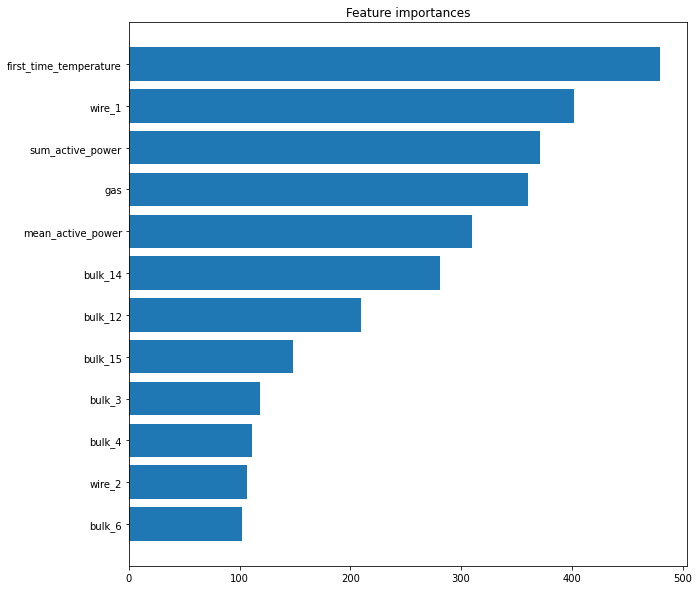

In [91]:
#Изучим влияние факторов на целевой признак для LGMBRegressor
importances_lgbm = model_lgbm.feature_importances_
indices_lgbm = np.argsort(importances_lgbm)
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.barh(range(features_train.shape[1]), importances_lgbm[indices_lgbm])
plt.yticks(range(features_train.shape[1]), [feature_names[i] for i in indices_lgbm])
plt.ylim([-1, features_train.shape[1]])
plt.show()

In [92]:
#Выведем в датафрейм полученные значения
df_lgbm = pd.DataFrame(data=np.sort(importances_lgbm), index=[feature_names[i] for i in indices_lgbm], columns=['coeffs'])
df_lgbm = df_lgbm[::-1]
df_lgbm

,coeffs
first_time_temperature,480
wire_1,402
sum_active_power,371
gas,360
mean_active_power,310
bulk_14,281
bulk_12,210
bulk_15,148
bulk_3,118
bulk_4,111


**Neural networks**

In [93]:
#Обучим нейронные сети
model_keras.fit(features_train, target_train, epochs=100, verbose=2, batch_size=10, 
                validation_data=(features_test, target_test))

Epoch 1/100
172/172 - 1s - loss: 2528054.7500 - mean_absolute_error: 1589.9353 - val_loss: 2490004.2500 - val_mean_absolute_error: 1577.9143 - 1s/epoch - 8ms/step
Epoch 2/100
172/172 - 1s - loss: 2063410.1250 - mean_absolute_error: 1424.7844 - val_loss: 1061900.6250 - val_mean_absolute_error: 1003.4877 - 598ms/epoch - 3ms/step
Epoch 3/100
172/172 - 1s - loss: 361113.5625 - mean_absolute_error: 498.0168 - val_loss: 157972.5000 - val_mean_absolute_error: 320.1243 - 572ms/epoch - 3ms/step
Epoch 4/100
172/172 - 1s - loss: 132154.3906 - mean_absolute_error: 292.6097 - val_loss: 102407.9219 - val_mean_absolute_error: 255.9675 - 544ms/epoch - 3ms/step
Epoch 5/100
172/172 - 1s - loss: 90900.6328 - mean_absolute_error: 239.1205 - val_loss: 75862.2812 - val_mean_absolute_error: 220.4579 - 625ms/epoch - 4ms/step
Epoch 6/100
172/172 - 1s - loss: 67684.1250 - mean_absolute_error: 205.2090 - val_loss: 58113.7188 - val_mean_absolute_error: 187.9353 - 528ms/epoch - 3ms/step
Epoch 7/100
172/172 - 1s - 

In [95]:
#Выведем все получившиеся данные в виде датафрейма
data = [['-', 5.87],
        [6.58, 6.5],
        [6.12, 5.91],
        [8.39, 7.12],
        ['-', 6.99]]
models = ['LightGBM', 'LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'Neural networks']
pd.DataFrame(data=data, index=models, columns=['Cross validation score', 'MAE on test'])

,Cross validation score,MAE on test
LightGBM,-,5.87
LinearRegression,6.58,6.50
RandomForestRegressor,6.12,5.91
DecisionTreeRegressor,8.39,7.12
Neural networks,-,6.99


### Вывод

Таким образом, лучшими моделями оказались LightGBM и RandomForestRegressor со значениями на тесте 5.87 и 5.91 соответственно, но считаю, что модель RandomForestRegressor может иметь более низкий MAE и быть гораздо лучше модели LightGBM, если подобрать больше параметров, но это скажется на длительности обучения.  

Самое низкое качество у моделей DecisionTreeRegressor (7.12) и Neural networks (6.99), скорее всего они подходят для обучения хуже, чем остальные.

У моделей LightGBM и RandomForestRegressor значение MAE на тесте < 6, что является хорошим показателем.

По графикам можно точно сказать, что главные факторы для определения целевого признака являются first_time_temperature (первый замер температуры для ключа по времени) и sum_active_power (суммарная активная мощность для ключа), остальные оказались менее влиятельным или невлиятельными вовсе.

# Общий вывод

Таким образом были проделаны следующие шаги:
1. Проведение исследовательского анализа данных:
- изучение всех датафреймов;
- выявление и работы с пропускам, дубликатами, выбросами и аномалиями для каждого датафрейма;
- приведение столбцов к стилистически корректному виду;
- вывод по процессу обработки;
2. Выявление признаков для обучения модели (целевой признак - температура);
3. Обучение моделей (LightGBM, LinearRegression, RandomForestRegressor, DecisionTreeRegressor, Neural networks) 
4. Тестирование моделей с достижением наименьшей метрики MAE (была достигнута для 2 моделей метрика < 6);

# Рекомендации

В поставленной задаче можно рассмотреть фактор разброса температур. Для этого необходимо:
1. Выявить границы, в пределах которых колебания температур допустимы;
2. Для температур, которые не входят в границы колебаний, получить дополнительную информацию по материалам и газу, которые использовались (например, химия материала или химический состав газа);

Тогда, после этого можно расширить задачу и повысить качество обученных моделей.

План отчёта из ноушена:


"В отчёте ответьте на вопросы:

Какие пункты плана были выполнены, а какие — нет (поясните почему)?
Какие трудности возникли и как вы их преодолели?
Какие ключевые шаги в решении задачи выделили?
Какая ваша итоговая модель и какое у неё качество?

# Отчёт

Были выполнены все пункты плана составленного плана.

- [x] **Проведение исследовательского анализа данных:**
- [x] изучение всех датафреймов;
- [x] выявление и работы с пропускам, дубликатами, выбросами и аномалиями для каждого датафрейма;
- [x] вывод по процессу обработки;
- [x] **Выявление признаков для обучения модели (целевой признак - температура);**
- [x] **Обучение моделей (LightGBM, LinearRegression, RandomForestRegressor, DecisionTreeRegressor, Нейронные сети) с достижением наименьшей метрики MAE;**
- [x] **Подведение итогов и вывод;**

Возникли трудности с обученией моделей, а именно с моделю LGBMRegressor, для неё не подбирались заданные мной параметры, поэтому пришлось обучить модель со стандартными параметрами, что в принципе позволило достигнуть необходимого качества метрики MAE.

Основными ключевыми шагами в решении поставленной задачи были анализ и обработка данных для подготовки признаков, а также и подбор признаков для обучения (1 и 2 пункты плана), что естественным образом сказалось и на высоких качествах моделей. 

Лучшими моделями оказались LightGBM и RandomForestRegressor со значениями МАЕ на тесте 5.87 и 5.91.